In [229]:
import pickle, numpy as np, pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils.extmath import randomized_svd
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

from nltk.corpus import stopwords

%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_colwidth = -1

## Load article data

In [230]:
with open('fox_urls2.pkl', 'rb') as picklefile:
    fox = pickle.load(picklefile)

with open('nyt_urls2.pkl', 'rb') as picklefile:
    nyt = pickle.load(picklefile)

## Helper functions:
### Preprocess article text
### Correctly categorize article sub-source
### Print top words from NMF model

In [228]:
# Most df urls that failed to scrape were from latino.dfnews.com
# df articles are a combo of dfNews, AP, and excerpts from the Washington Examiner (and perhaps more)
# I can't reliably tell them apart from this data.
# Some AP articles start with (AP), but not all.
# Some WashEx articles start with "!--StartFragment-->", but not all

def process_fox(df):
    df['mysource'] = 'fox'

    df.date = pd.to_datetime(df.date)
    df.description.fillna('', inplace=True)
    
    # Drop articles where scraping failed
    df = df[df.text != '']
    
    # Label articles that are transcripts, or definitely come from AP or Washington Examiner
    df.loc[df.text.str.contains('foxnews.com', case=False), 'type'] = 'fox report'
    df.loc[df.text.str.contains('rush transcript', case=False), 'type'] = 'transcript'
    df.loc[df.url.str.contains('transcript'), 'type'] = 'transcript'
    df.loc[df.description.str.contains('\(AP\)'), 'type'] = 'AP'
    df.loc[df.text.str.contains('The Associated Press contributed'), 'type'] = 'AP'
    df.loc[df.text.str.contains('!--StartFragment-->', case=False), 'type'] = 'examiner'
    
    # Remove unencoded quotes
    df.text.replace(u'\u2018', '', inplace=True)
    df.text.replace(u'\u2019', '', inplace=True)
    df.text.replace(u'\u201c', '', inplace=True)
    df.text.replace(u'\u201d', '', inplace=True)
    df.text.replace(u'\u2014', '', inplace=True)

    # Remove the 'buzz cut' articles, which are a mashup of topics
    df = df[~df.text.str.contains('buzz cut', case=False)]    
    
    # Remove non-article text
    df.text = df.text.str.replace('!--StartFragment-->', '', case=False)
    df.text = df.text.str.replace(r'\(CROSSTALK\)', '')
    df.text = df.text.str.replace(r'\(LAUGHTER\)', '')
    df.text = df.text.str.replace(r'\(INAUDIBLE\)', '')
    df.text = df.text.str.replace(r'\(COMMERCIAL BREAK\)', '')
    df.text = df.text.str.replace(r'\([ A-Z]*?VIDEO CLIP[ A-Z]*\)', '')
    df.text = df.text.str.replace(r'\([ A-Z]*?VIDEOTAPE[ A-Z]*\)', '')
    df.text = df.text.str.replace(r'[A-Z]+\'?[A-Z]+ [A-Z]+\'?[A-Z]+:?', '') # Remove things like "SAM O'KENNEDY:" from transcripts, while keeping things like "ISIS" or "NATO"
    df.text = df.text.str.replace(r'[A-Z]+\'?[A-Z]+:', '') # Remove things like "MARTIN:" from transcripts, while keeping things like "ISIS" or "NATO"
    df.text = df.text.str.replace(u'\(AP\)', '')
    df.text = df.text.str.replace('This is a rush transcript.*?final form and may be updated\.', '', case=False)
    df.text = df.text.str.replace('Watch "The O\'Reilly Factor" weeknights at 8 p\.m\. and 11 p\.m\. ET!', '')
    df.text = df.text.str.replace('Content and Programming Copyright 2015 Fox News Network.*?from copies of the content\.', '')
    df.text = df.text.str.replace('Fox News.*?contributed to this report\.', '')
    df.text = df.text.str.replace('http://.*?\s', '')
    
    # Remove 'United States' and 'United Nations' because 'united' is one of my moral foundations words
    df.text = df.text.str.replace('United Nations', '', case=False)
    df.text = df.text.str.replace('United States', '', case=False)
    
    df.index = range(len(df))
    
    return df

def process_nyt(df):
    df['mysource'] = 'nyt'
    
    df['date'] = df.pub_date
    df.date = pd.to_datetime(df.date)
    
    
    df['url'] = df.web_url
    df['description'] = df.abstract

    # Remove obituaries and reviews and articles that couldn't be scraped
    df = df[df.type_of_material != 'Paid Death Notice']
    df = df[df.type_of_material != 'Review']
    df = df[(df.text != '') &
            (df.text != 'NYTimes.com no longer supports Internet Explorer 9 or earlier. Please upgrade your browser.')]

    # Get main headline from dict of headlines
    df.headline = df.headline.apply(lambda x: x['main'])
    df['title'] = df.headline
    
    # Remove unencoded quotes
    df.text.replace(u'\u2018', '', inplace=True)
    df.text.replace(u'\u2019', '', inplace=True)
    df.text.replace(u'\u201c', '', inplace=True)
    df.text.replace(u'\u201d', '', inplace=True)
    df.text.replace(u'\u2014', '', inplace=True)
    
    # Remove non-article text
    df.text = df.text.str.replace('Advertisement Continue reading the main story', '', case=False)
    df.text = df.text.str.replace('To the Editor:', '', case=False)
    df.text = df.text.str.replace('(AP )?Photo\n\n', '')
    df.text = df.text.str.replace("Please verify you're not a robot by clicking the box. Invalid email address. Please re-enter. You must select a newsletter to subscribe to. Sign Up Receive occasional updates and special offers for The New York Times's products and services. Thank you for subscribing. An error has occurred. Please try again later. View all New York Times newsletters.", '')
    df.text = df.text.str.replace("Sign Up for the Opinion Today Newsletter Every weekday, get thought-provoking commentary from Op-Ed columnists, the Times editorial board and contributing writers from around the world.", '')

    # Remove 'United States' and 'United Nations' because 'united' is one of my moral foundations words
    df.text = df.text.str.replace('United Nations', '', case=False)
    df.text = df.text.str.replace('United States', '', case=False)

    
    df.drop(['pub_date', 'web_url', 'headline', 'abstract'], axis=1, inplace=True)
    df.index = range(len(df))

    return df

    
def print_top_words(model, feature_names, n_top_words):
    """
    Prints the highest-weighted words for each topic in an NMF model
    """
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
    

## Preprocess articles and concatenate both data frames

In [4]:
stop_words = stopwords.words('english')

In [231]:
fox = process_fox(fox)
nyt = process_nyt(nyt)

In [233]:
articles = fox.append(nyt, ignore_index=True)

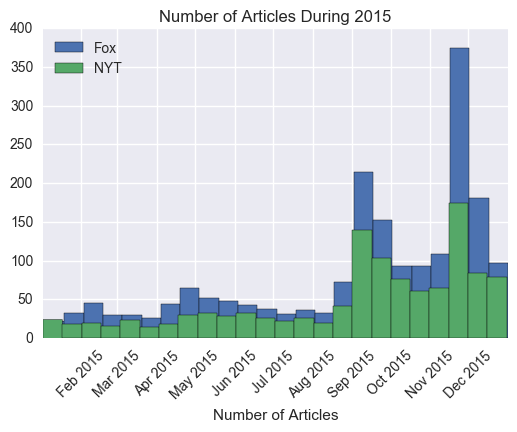

In [372]:
articles.groupby('mysource').date.hist(bins = 24, xrot=45)
plt.legend(labels=['Fox', 'NYT'], loc='best')
plt.xlabel('Number of Articles')
plt.title('Number of Articles During 2015')

## Topic analysis on all articles using Non-negative Matrix Factorization

In [235]:
# TFIDF vectorize the text
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, decode_error='ignore', ngram_range=(1,1),
                                       stop_words=stop_words)

In [236]:
all_tfidf = tfidf_vectorizer.fit_transform(articles.text)

[ 13.43506573   7.56945173   5.44637751   4.80376747   4.60509095
   4.32025203   4.30050398   4.11719223   3.9779717    3.81389469
   3.80604949   3.7091009    3.57883323   3.43378648   3.3282017
   3.2988989    3.26962575   3.15810457   3.14668632   3.08920094]


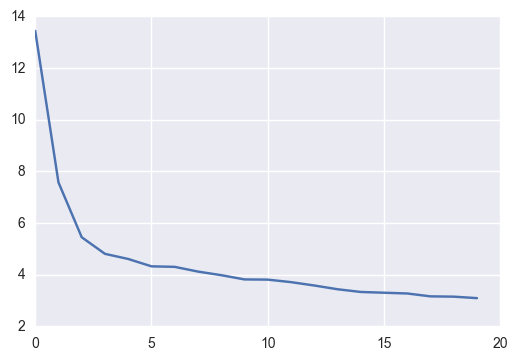

In [237]:
# Look for elbow to determine how many topics I should use
u, s, vt = randomized_svd(all_tfidf, n_components=20, random_state=42)

print s
plt.plot(s[:20]);

In [238]:
# Run NMF with 3 topics
nmf1 = NMF(n_components=3, random_state=1).fit(all_tfidf)
topic_percentages = nmf1.transform(all_tfidf)

In [374]:
# Print top words for each topic
# This didn't result in very coherent topics!
# Topic #1 seems to be focused on the conversational speech of the Fox News transcripts

all_tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf1, all_tfidf_feature_names, 12)

Topic #0:
migrants, european, europe, said, germany, hungary, eu, border, asylum, greece, people, union
Topic #1:
think, trump, know, going, right, isis, people, well, president, like, want, get
Topic #2:
said, refugees, syrian, mr, syria, state, islamic, obama, refugee, security, government, president
()


In [ ]:
# Save articles for each topic, to inspect
for x in topics.unique():
    articles[topics == x].to_csv('topic'+str(x)+'.csv', encoding='utf-8')

## NMF on NYT data only

In [240]:
tfidf_vectorizer_nyt = TfidfVectorizer(max_df=0.95, min_df=2, decode_error='ignore', ngram_range=(1,1),
                                       stop_words=stop_words)

nyt_letters = nyt[(nyt.news_desk == 'OpEd') | (nyt.news_desk == 'Editorial') | (nyt.news_desk == 'Letters')]

In [241]:
nyt_tfidf = tfidf_vectorizer_nyt.fit_transform(nyt_letters.text)

[ 4.32863578  2.28228864  2.19006079  1.86140322  1.78705773  1.66055322
  1.59947387  1.56312059  1.54605915  1.50507756  1.4964295   1.4399422
  1.42728706  1.398057    1.38208412  1.37093956  1.3461792   1.32787372
  1.30411619  1.2979307 ]


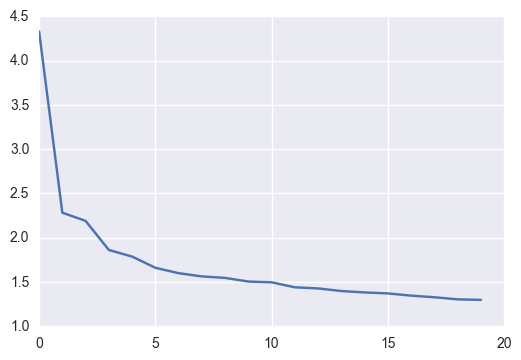

In [242]:
u2, s2, vt2 = randomized_svd(nyt_tfidf, n_components=20, random_state=42)

print s2
plt.plot(s2[:20]);

In [243]:
nmf2 = NMF(n_components=3, random_state=1).fit(nyt_tfidf)
topic_percentages2 = nmf2.transform(nyt_tfidf)

In [244]:
# Upon inspection, results aren't much better than above.

nyt_tfidf_feature_names = tfidf_vectorizer_nyt.get_feature_names()
print_top_words(nmf2, nyt_tfidf_feature_names, 10)

Topic #0:
mr, american, refugees, would, syrian, syria, president, state, isis, islamic
Topic #1:
feedback, interested, page, tell, think, us, front, trump, york, mother
Topic #2:
european, europe, union, migrants, refugees, germany, greece, crisis, 000, italy
()


In [245]:
# How many articles primarily represent each topic?
topics2 = pd.Series(np.argmax(topic_percentages2, axis=1))
topics2.value_counts().sort_index()

0    154
1    5  
2    96 
dtype: int64

# Moral Foundations Analysis

## Create MF word lookup tables

In [232]:
mf_dict = pd.read_csv('moral foundations dict edited.csv')

mf_stem_lookup = mf_dict.groupby('word').first().reset_index()
mf_stem_lookup = mf_stem_lookup.loc[:, ['word', 'word_stem']]

mf_group_lookup = mf_dict.groupby(['word_stem', 'mf']).first().reset_index().loc[:,['word_stem', 'mf']]

## Helper functions
### Preprocess article text for Moral Foundations analysis
### Do significance test between proportions of certain words in NYT and Fox News

In [246]:
def mf_analysis(text, vectorizer):
    '''
    This function TF-vectorizes the article text and returns a dataframe with
    term frequency, article index, and word stem information for each word.
    
    text: Series or list of strings. Each will be treated as a data point.
    vectorizer: TF vectorizer
    '''
    tf_compressed_data = vectorizer.fit_transform(text)
    feature_names = pd.Series(vectorizer.get_feature_names())
    
    df = pd.DataFrame(tf_compressed_data.toarray(), columns=feature_names)
    #df = df.div(df.sum(axis=1), axis=0)
    #df = df.loc[:, df.columns.isin(mf_dict.word)] 
    #df.replace(0, np.nan, inplace=True)
    
    df = df.stack().reset_index()
    df.columns = ['article', 'word', 'tf']
    
    df = df.merge(mf_stem_lookup, how='left', on='word')
    
    return df


def prop_test(c1, c2, n1, n2):
    """
    Does a z test between two proportions to determine statistical significance.
    c1 and n1: number of successes and number of trials for category one
    c2 and n2: number of successes and number of trials for category two
    returns: p value
    """
    n1 = float(n1)
    n2 = float(n2)
    p1 = c1/n1
    p2 = c2/n2
    p = (c1+c2)/(n1+n2)
    
    numer = p1-p2
    denom = (p*(1-p)*(1/n1 + 1/n2))**.5
    z = numer/denom
    p = st.norm.sf(abs(z))*2
    
    return p

## Compare frequencies of Moral Foundations words between Fox and NYT

In [ ]:
mf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=0, decode_error='ignore', ngram_range=(1,1),
                                   stop_words=stop_words, use_idf=False, norm=None)

In [247]:
df = mf_analysis(articles.text, mf_vectorizer)

In [248]:
df.head()

,article,word,tf,word_stem
0,0,00,0.0,NaN
1,0,000,0.0,NaN
2,0,0000,0.0,NaN
3,0,00001,0.0,NaN
4,0,0004,0.0,NaN


In [249]:
# Merge in moral foundation word stems
df2 = df.merge(articles.mysource.to_frame(), how='left', left_on='article', right_index=True)

In [250]:
# Get total word count for Fox and NYT
source_total_words = df2.groupby('mysource').tf.sum()
print source_total_words

fox_total_words = source_total_words['fox']
nyt_total_words = source_total_words['nyt']

mysource
fox    989808.0
nyt    479051.0
Name: tf, dtype: float64


In [251]:
# Keep only moral foundation words in DF
df_mwords = df2.dropna(subset=['word_stem']) 
df_mwords.head(10)

,article,word,tf,word_stem,mysource
1112,0,abandon,0.0,abandon,fox
1113,0,abandoned,0.0,abandon,fox
1114,0,abandoning,0.0,abandon,fox
1116,0,abandons,0.0,abandon,fox
1208,0,abide,0.0,abide,fox
1302,0,abstention,0.0,abstinence,fox
1303,0,abstentions,0.0,abstinence,fox
1304,0,abstinence,0.0,abstinence,fox
1326,0,abuse,0.0,abuse,fox
1327,0,abused,0.0,abuse,fox


In [252]:
# Get counts for each word, by source
word_counts_by_source = df_mwords.groupby(['mysource', 'word_stem']).tf.sum().reset_index()
word_counts_by_source

,mysource,word_stem,tf
0,fox,abandon,160.0
1,fox,abide,2.0
2,fox,abstinence,5.0
3,fox,abuse,145.0
4,fox,adultery,3.0
5,fox,agitate,8.0
6,fox,alienates,28.0
7,fox,allegiance,38.0
8,fox,allied,307.0
9,fox,amity,0.0


In [253]:
# Get frequencies for each word, by source
word_freq_by_source = word_counts_by_source.merge(source_total_words.to_frame(name='source_total'), how='left', left_on='mysource',
                                                     right_index=True)
word_freq_by_source.tf = word_freq_by_source.tf/word_freq_by_source.source_total

In [283]:
print word_freq_by_source[word_freq_by_source.mysource == 'fox'].sort_values('tf', ascending=False)[:10], '\n'
print word_freq_by_source[word_freq_by_source.mysource == 'nyt'].sort_values('tf', ascending=False)[:10]


    mysource    word_stem        tf  source_total  freq_diff
13   fox      attack       0.003030  989808.0     NaN       
209  fox      terrorist    0.002418  989808.0     NaN       
231  fox      war          0.002250  989808.0     NaN       
101  fox      group        0.002132  989808.0     NaN       
187  fox      security     0.001993  989808.0     NaN       
128  fox      kill         0.001646  989808.0     NaN       
99   fox      good         0.001598  989808.0     NaN       
92   fox      family       0.001471  989808.0     NaN       
96   fox      fight        0.001411  989808.0     NaN       
114  fox      immigration  0.001158  989808.0     NaN        

    mysource    word_stem        tf  source_total  freq_diff
469  nyt      war          0.002780  479051.0      0.000531 
339  nyt      group        0.002505  479051.0      0.000373 
330  nyt      family       0.001941  479051.0      0.000470 
425  nyt      security     0.001931  479051.0      0.000062 
251  nyt      attack  

In [254]:
# Find top 10 words with most different frequencies by source

word_freq_by_source['freq_diff'] = word_freq_by_source.sort_values('mysource').groupby('word_stem').tf. \
    apply(lambda x: abs(x-x.shift()))
top_10_diff_mfwords = word_freq_by_source.sort_values('freq_diff', ascending=False).word_stem.head(10)

In [255]:
top_10_diff_mfwords

251    attack   
337    good     
447    terrorist
469    war      
366    kill     
330    family   
377    member   
372    leader   
339    group    
418    right    
Name: word_stem, dtype: object

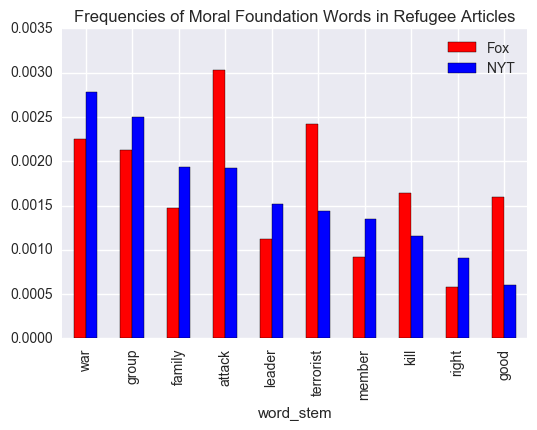

In [383]:
# Chart the words with the most different frequencies between sources

word_freq_by_source.loc[word_freq_by_source.word_stem.isin(top_10_diff_mfwords), ['mysource', 'tf', 'word_stem']]. \
    pivot(index='word_stem', columns='mysource', values='tf').sort_values('nyt', ascending=False). \
    plot(kind='bar', cmap='bwr_r')
#plt.xlabel('Proportion of Total Words')
plt.title('Frequencies of Moral Foundation Words in Refugee Articles')
plt.legend(labels=['Fox', 'NYT'], loc='best')

## Check statistical significance of these differences using a z test for proportions

In [257]:
for_signif_test = word_counts_by_source.pivot(index='mysource', columns='word_stem', values='tf')
for_signif_test

word_stem,abandon,abide,abstinence,abuse,adultery,agitate,alienates,allegiance,allied,amity,...,virginity,virtuous,wanton,war,wholesome,wicked,worthy,wounding,wretched,wrong
mysource,,,,,,,,,,,,,,,,,,,,,
fox,160.0,2.0,5.0,145.0,3.0,8.0,28.0,38.0,307.0,0.0,...,8.0,2.0,1.0,2227.0,1.0,0.0,103.0,156.0,5.0,424.0
nyt,150.0,6.0,3.0,92.0,2.0,5.0,13.0,10.0,136.0,1.0,...,7.0,1.0,0.0,1332.0,0.0,1.0,41.0,117.0,3.0,72.0


In [258]:
# Get unadjusted p-values for each word

p_vals = []
for col in for_signif_test.columns:
    fox_count = for_signif_test.loc['fox', col]
    nyt_count = for_signif_test.loc['nyt', col]
    
    p_vals.append(prop_test(fox_count, nyt_count, fox_total_words, nyt_total_words))

In [259]:
# Use bonferroni adjustment for multiple comparisons
# Print p-values that are less than my adjusted alpha level (i.e. less than .05-adjusted)
# All words from the chart above are included here!

p_vals_df = pd.DataFrame(p_vals, columns=['p_vals'], index=for_signif_test.columns)
a = .05
bonferroni_adj = a/len(p_vals_df)
p_vals_df[p_vals_df.p_vals < bonferroni_adj].sort_values('p_vals')

,p_vals
word_stem,
good,4.234656e-57
terrorist,5.034354e-34
attack,6.031911e-34
empathic,6.917663e-21
wrong,8.037071e-18
homeland,1.008809e-17
member,8.452289e-14
kill,3.291616e-13
right,1.828200e-12


## What are the most commonly used Moral Foundations words across both sources?

In [284]:
# The most common words are in the Harm and Ingroup categories

mf_word_total_freqs = (word_counts_by_source.groupby('word_stem').sum(). \
    merge(mf_group_lookup, how='left', left_index=True, right_on='word_stem'))
mf_word_total_freqs.tf = mf_word_total_freqs.tf/(source_total_words.sum())
mf_word_total_freqs.sort_values('tf', ascending=False, inplace=True)

print mf_word_total_freqs
print mf_word_total_freqs.groupby('mf').sum().sort_values('tf', ascending=False)

# mf_word_total_freqs.merge(mf_group_lookup, how='left', left_index=True, right_on='word_stem')

               tf         word_stem               mf
19   2.670100e-03  attack            HarmVice       
289  2.422969e-03  war               HarmVice       
117  2.253450e-03  group             IngroupVirtue  
255  2.098227e-03  terrorist         IngroupVice    
230  1.972960e-03  security          HarmVirtue     
108  1.624390e-03  family            IngroupVirtue  
155  1.484826e-03  kill              HarmVice       
112  1.340496e-03  fight             HarmVice       
115  1.272416e-03  good              MoralityGeneral
162  1.256077e-03  leader            AuthorityVirtue
134  1.210463e-03  immigration       IngroupVice    
177  1.126044e-03  nation            IngroupVirtue  
171  1.064091e-03  member            IngroupVirtue  
157  9.878416e-04  law               AuthorityVirtue
114  9.006991e-04  foreign           IngroupVice    
228  8.891255e-04  safety            HarmVirtue     
56   8.121950e-04  controlled        AuthorityVirtue
285  7.904094e-04  violently         HarmVice 

## Cluster articles based on which Moral Foundations axes they are concerned with

In [ ]:
# Get proportions of moral foundation groups for clustering
df3 = df2.merge(mf_group_lookup, how='left', on='word_stem')
df3.mf = df3.mf.fillna('none')

In [291]:
df3.head(20)

,article,word,tf,word_stem,mysource,mf
0,0,00,0.0,NaN,fox,none
1,0,000,0.0,NaN,fox,none
2,0,0000,0.0,NaN,fox,none
3,0,00001,0.0,NaN,fox,none
4,0,0004,0.0,NaN,fox,none
5,0,000japanese,0.0,NaN,fox,none
6,0,000refugees,0.0,NaN,fox,none
7,0,000syrian,0.0,NaN,fox,none
8,0,000th,0.0,NaN,fox,none
9,0,001,0.0,NaN,fox,none


In [292]:
df3.tf = df3.groupby('article').tf.transform(lambda x: x/sum(x))

In [293]:
df4 = df3.groupby(['mysource', 'article', 'mf']).tf.sum()

In [351]:
# The proportions of MF axes for Fox and NYT as a whole look very similar

print df4.reset_index().groupby(['mysource', 'mf']).tf.mean().reset_index().sort_values(['mysource', 'tf'], ascending=
                                                                                     [True, False])

   mysource               mf        tf
11  fox      none             0.950863
4   fox      HarmVice         0.011545
7   fox      IngroupVirtue    0.010275
5   fox      HarmVirtue       0.006896
1   fox      AuthorityVirtue  0.006688
6   fox      IngroupVice      0.005358
8   fox      MoralityGeneral  0.002784
0   fox      AuthorityVice    0.002596
3   fox      FairnessVirtue   0.001532
10  fox      PurityVirtue     0.000732
9   fox      PurityVice       0.000417
2   fox      FairnessVice     0.000315
23  nyt      none             0.953862
16  nyt      HarmVice         0.010735
19  nyt      IngroupVirtue    0.009011
13  nyt      AuthorityVirtue  0.007189
17  nyt      HarmVirtue       0.006261
18  nyt      IngroupVice      0.004376
20  nyt      MoralityGeneral  0.003089
12  nyt      AuthorityVice    0.002213
15  nyt      FairnessVirtue   0.001705
22  nyt      PurityVirtue     0.000728
21  nyt      PurityVice       0.000526
14  nyt      FairnessVice     0.000305


In [ ]:
df5 = df4.unstack()

In [358]:
source_total_words.sum()

1468859.0

In [327]:
# Now I've calculated proportions for each article
df5.head()

mf                AuthorityVice  AuthorityVirtue  FairnessVice  \
mysource article                                                 
fox      0        0.005405       0.005405         0.0            
         1        0.000000       0.018824         0.0            
         2        0.000000       0.014286         0.0            
         3        0.000000       0.000000         0.0            
         4        0.000000       0.013158         0.0            

mf                FairnessVirtue  HarmVice  HarmVirtue  IngroupVice  \
mysource article                                                      
fox      0        0.002703        0.013514  0.018919    0.002703      
         1        0.028235        0.009412  0.002353    0.004706      
         2        0.000000        0.014286  0.000000    0.014286      
         3        0.000000        0.016949  0.000000    0.000000      
         4        0.000000        0.000000  0.000000    0.000000      

mf                IngroupVirtue  MoralityGeneral  PurityVice  PurityVirtue  \
mysource article                                                             
fox      0        0.000000       0.035135         0.008108    0.0            
         1        0.011765       0.011765         0.002353    0.0            
         2        0.000000       0.000000         0.000000    0.0            
         3        0.016949       0.000000         0.000000    0.0            
         4        0.000000       0.013158         0.000000    0.0            

mf                    none  
mysource article            
fox      0        0.908108  
         1        0.910588  
         2        0.957143  
         3        0.966102  
         4        0.973684

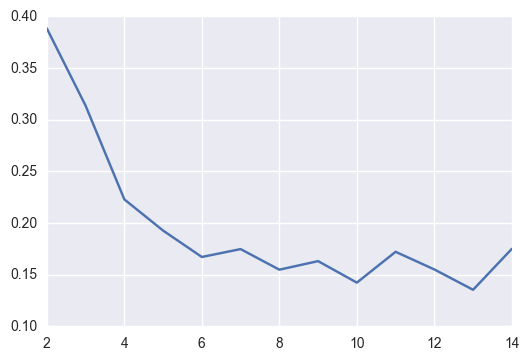

In [345]:
# Use k-means to cluster the articles
# Look for an elbow in the silhouette score to determine how many clusters to use

s_score = []
for i in range(2,15):
    kmeans = MiniBatchKMeans(n_clusters=i, random_state=44)
    clusters = kmeans.fit_predict(df5)
    s_score.append(silhouette_score(df5, kmeans.labels_))
    
    
plt.plot(range(2,15), s_score)

In [346]:
km1 = MiniBatchKMeans(n_clusters=6, random_state=44)
clusters2 = km1.fit_predict(df5)

In [347]:
# Calculate mean Moral Foundation Axis proportions for each cluster
mf_score_clusters = df5.groupby(clusters2).mean()

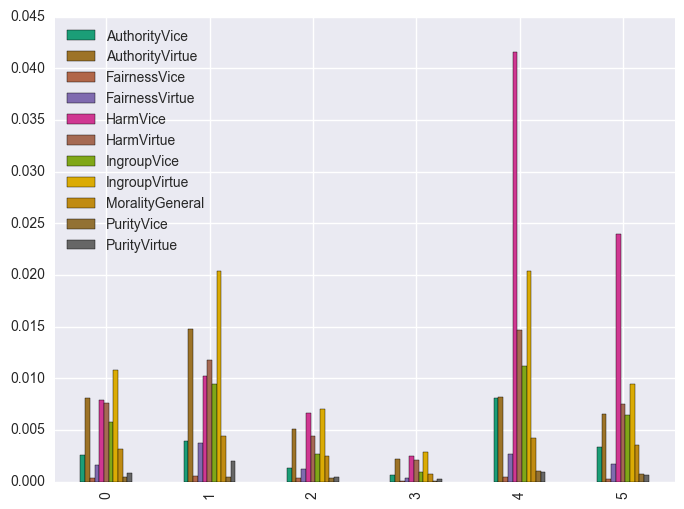

In [348]:
# Chart the mean proportions for each cluster
mf_score_clusters.iloc[:,:-1].plot(kind='bar', figsize=(8,6), cmap='Dark2').legend(loc='best')

In [316]:
# Export articles by cluster for further inspection
for x in np.unique(clusters2):
    articles[clusters2 == x].to_csv('mf_cluster'+str(x)+'.csv', encoding='utf-8')